# 5510 Final Project - Unsupervised Learning on Country Data

Kaggle: https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data?utm_source=chatgpt.com&select=Country-data.csv


## 1) Project Setup

In [2]:
# System stuff
import os
import sys
from pathlib import Path

# Basic data science
import random
import numpy as np
import pandas as pd
import math
import statsmodels.api as sm

import kagglehub   # need this to download dataset

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

# Scikit-learn (including 3 or 4 that I didn't end up keeping in the final code.
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_selection import chi2
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from wordcloud import WordCloud
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay,
    mean_squared_error, mean_absolute_error, r2_score,
    f1_score, accuracy_score, precision_score, recall_score, silhouette_score
)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Plotting defaults
sns.set_theme(context="notebook", style="darkgrid", palette="deep")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 300,
    "axes.titlesize": 14,
    "axes.labelsize": 12
})
# helper function to delimit sections in data output
def section_split(width=200, char="-"):
    print("\n", char * width, "\n")

# helper function to save figures
def save_figure(name=None, dpi=300, bbox_inches='tight', pad_inches=0.1):
    # Create directory if it doesn't exist
    save_dir = "figs/5510_mini_project"
    os.makedirs(save_dir, exist_ok=True)
    # Generate filename
    if name is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"chart_{timestamp}.png"
    else:
        # Clean the name to be filename-safe
        filename = "".join(c for c in name if c.isalnum() or c in (' ', '-', '_')).rstrip()
        filename = filename.replace(' ', '_')
        if not filename.endswith('.png'):
            filename += '.png'
    # Full path
    filepath = os.path.join(save_dir, filename)
    # Save the figure
    plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches, pad_inches=pad_inches)
    print(f"Figure saved: {filepath}")
    return filepath

print("Python:", sys.version.split()[0])
print("Pandas:", pd.__version__)

Python: 3.11.13
Pandas: 2.3.2


In [3]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("rohan0301/unsupervised-learning-on-country-data")
print("Path to dataset files:", path)

ConnectionError: HTTPSConnectionPool(host='www.kaggle.com', port=443): Max retries exceeded with url: /api/v1/datasets/view/rohan0301/unsupervised-learning-on-country-data (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x127902390>: Failed to resolve 'www.kaggle.com' ([Errno 8] nodename nor servname provided, or not known)"))

In [12]:
# for now, avoid the need to download the dataset
path = "/Users/seancoffey/.cache/kagglehub/datasets/rohan0301/unsupervised-learning-on-country-data/versions/2"

p = Path(path)
files = [f.name for f in p.iterdir() if f.is_file()]
print("Files in folder:")
for name in files:
    print("-", name)

csv_files = sorted(p.rglob("*.csv"))  # search recursively
if not csv_files:
    raise FileNotFoundError(f"No CSV files found under {p}")
country_data = pd.read_csv(csv_files[0])
country_dict = pd.read_csv(csv_files[1])
print("Loaded:", csv_files[0].name, country_data.shape)
print("Loaded:", csv_files[1].name, country_dict.shape)
display(country_data.head())
display(country_dict)

Files in folder:
- data-dictionary.csv
- Country-data.csv
Loaded: Country-data.csv (167, 10)
Loaded: data-dictionary.csv (10, 2)


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


,Column Name,Description
0,country,Name of the country
1,child_mort,Death of children under 5 years of age per 100...
2,exports,Exports of goods and services per capita. Give...
3,health,Total health spending per capita. Given as %ag...
4,imports,Imports of goods and services per capita. Give...
5,Income,Net income per person
6,Inflation,The measurement of the annual growth rate of t...
7,life_expec,The average number of years a new born child w...
8,total_fer,The number of children that would be born to e...
9,gdpp,The GDP per capita. Calculated as the Total GD...


In [5]:
country_data.describe()


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


Figure saved: figs/5510_mini_project/histograms.png


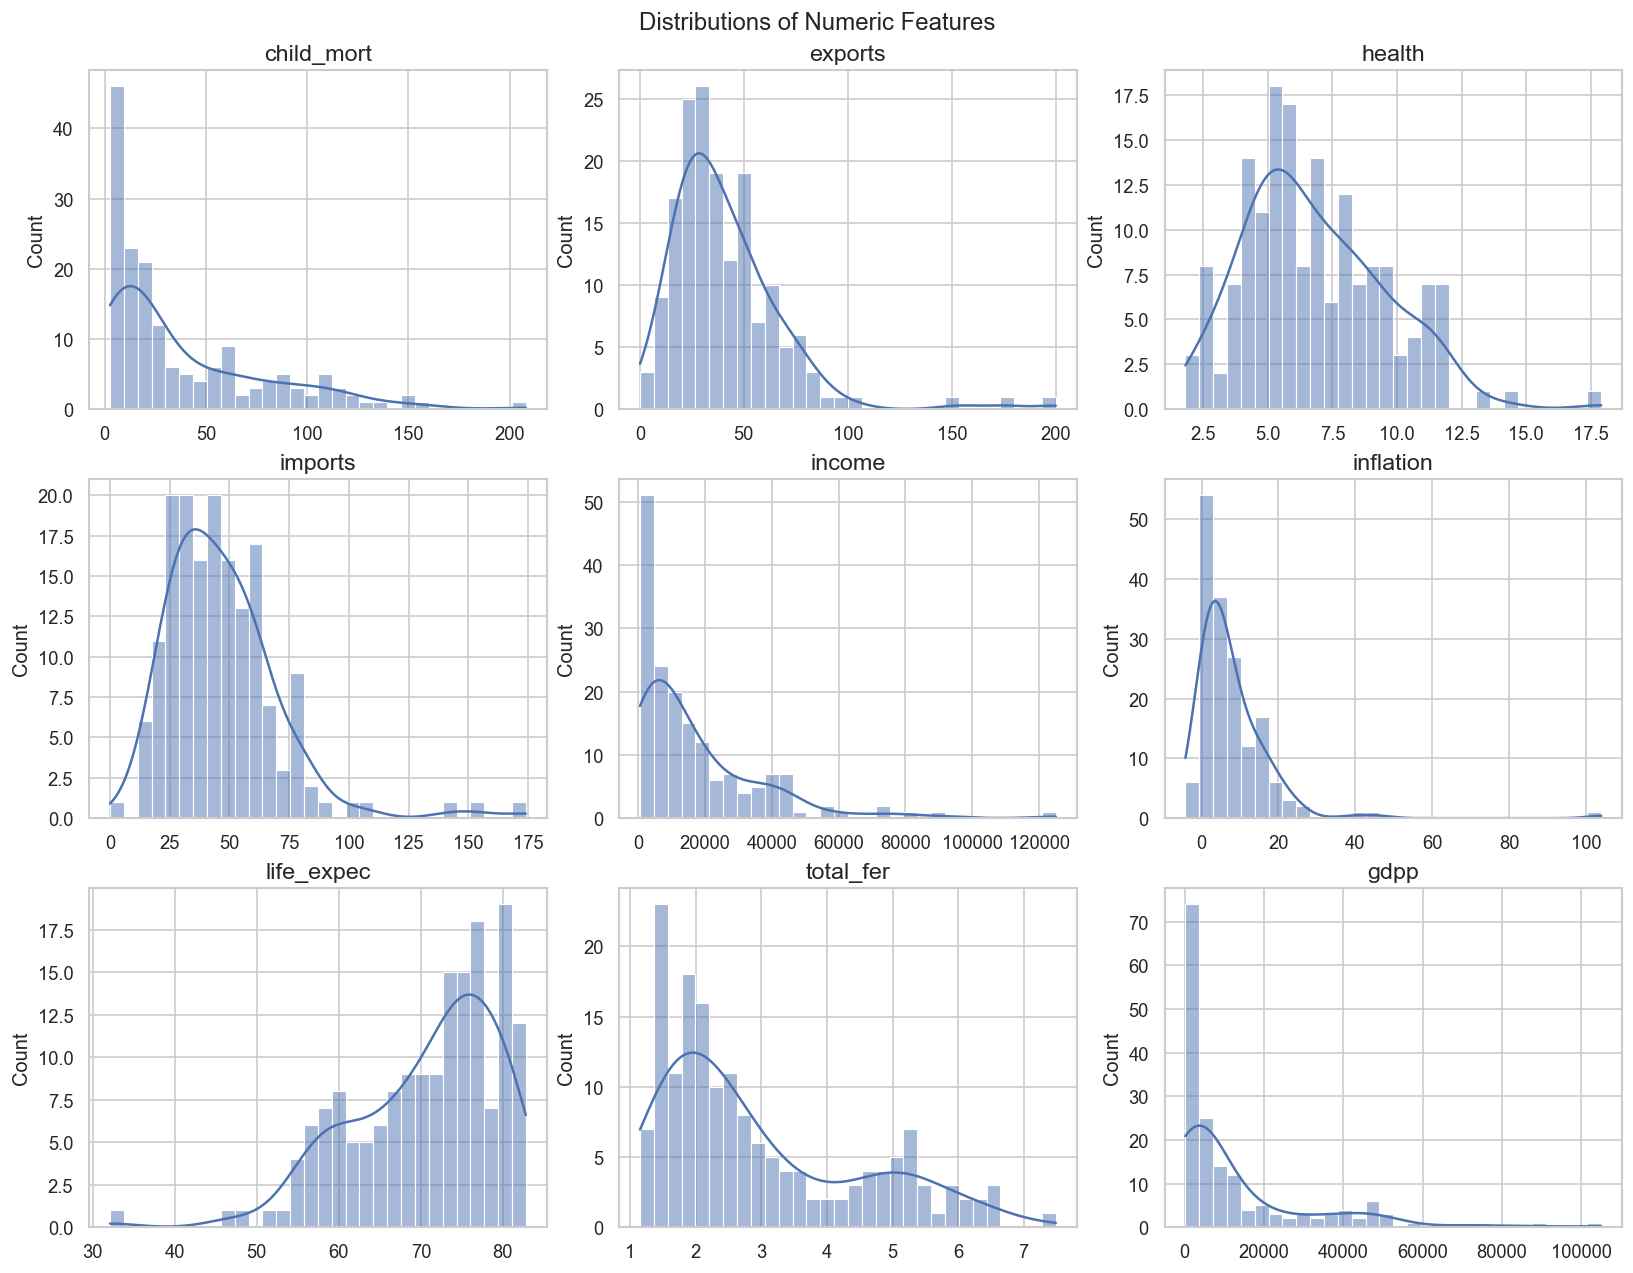


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 

Figure saved: figs/5510_mini_project/outliers.png


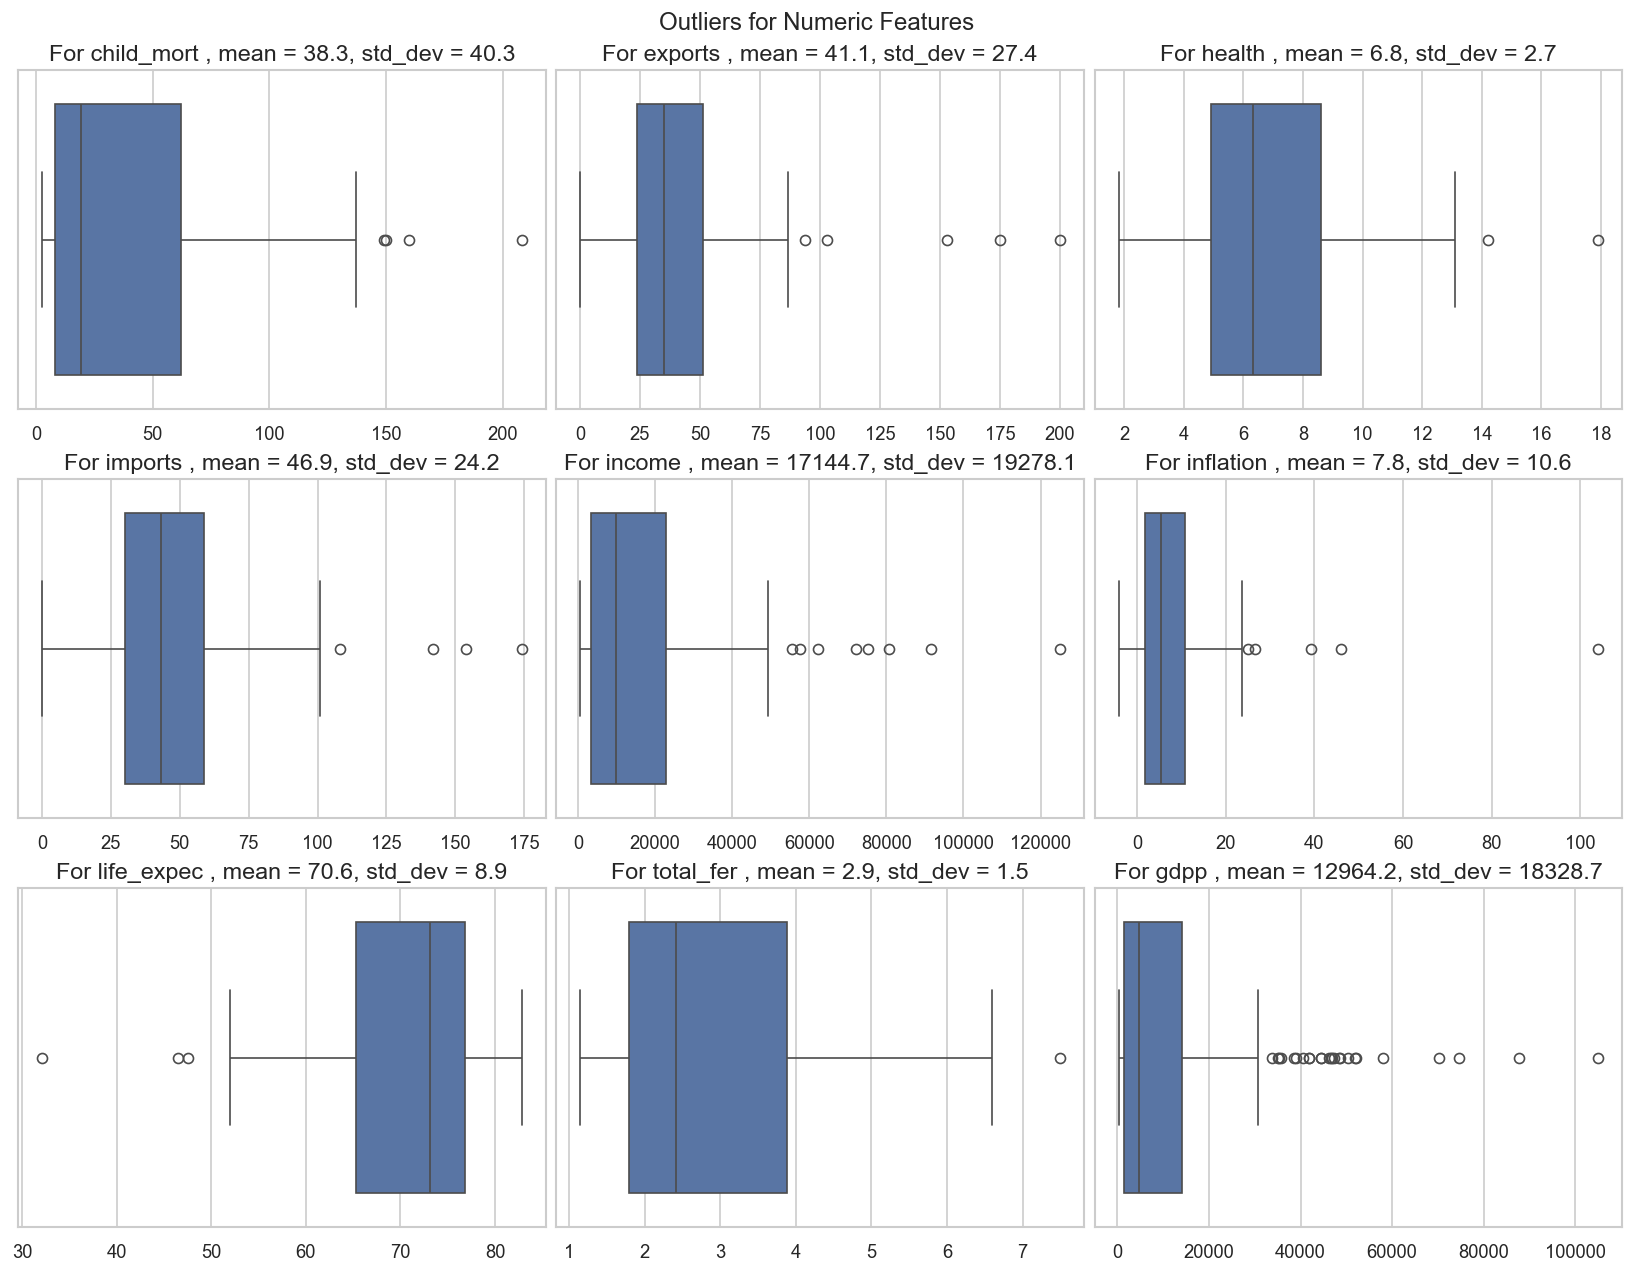


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 

Figure saved: figs/5510_mini_project/num_cols_corr.png


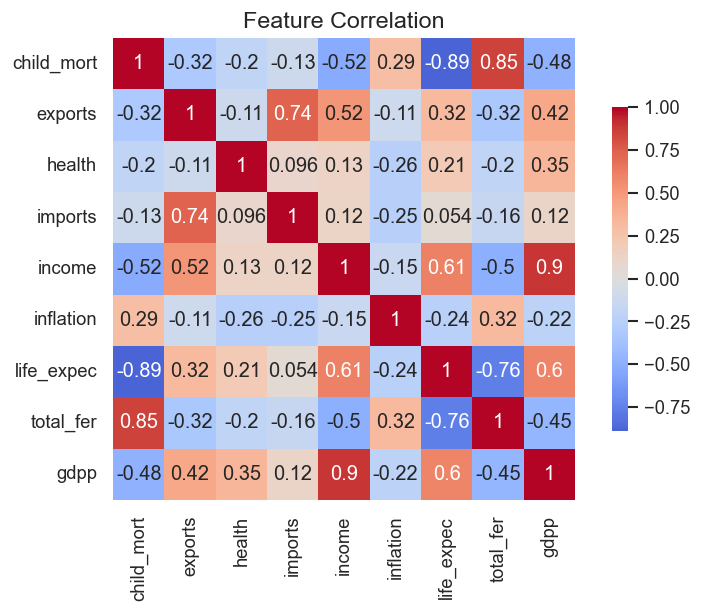


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



In [23]:
## Let's start with a simple pairplot
## sns.pairplot(country_data, vars=num_cols, diag_kind="kde")
## save_figure("num_cols_pairplot")
## plt.show()

def setup_plot_grid(data = country_data, num_cols = num_cols, n_cols = 3):
    n = len(num_cols)
    n_cols = n_cols
    n_rows = math.ceil(n / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 3.5), constrained_layout=True)
    axes = np.array(axes).reshape(-1)  # flatten in case of single row/col

    return fig, axes


def plot_hist(data=country_data, num_cols=num_cols, filename="histograms"):

    fig, axes = setup_plot_grid(data, n_cols = n_cols)

    for i, col in enumerate(num_cols):
        ax = axes[i]
        sns.histplot(country_data[col].dropna(), bins=30, kde=True, ax=ax)
        ax.set_title(col)
        ax.set_xlabel("")
        ax.set_ylabel("Count")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle("Distributions of Numeric Features")
    save_figure(filename)
    plt.show()
    return

def plot_outliers(data=country_data, num_cols=num_cols, filename="outliers"):
    #colors = ["skyblue", "salmon", "lightgreen", "orange", "violet", "gold"]

    fig, axes = setup_plot_grid(data, n_cols = n_cols)

    for i, col in enumerate(num_cols):
        ax = axes[i]
        sns.boxplot(x = country_data[col], ax=ax)
        box_title = f"For {col} , mean = {country_data[col].mean():.1f}, std_dev = {country_data[col].std():.1f}"
        ax.set_title(box_title)
        ax.set_xlabel("")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle("Outliers for Numeric Features")
    save_figure(filename)
    plt.show()
    return

num_cols = country_data.select_dtypes(include=["int", "float"]).columns.tolist()
n_cols = 3 # Allows definition of a consistent grid depending on number of charts per row.

plot_hist(country_data)
section_split()
plot_outliers(country_data)
section_split()
# Correlation heatmap
corr = country_data[num_cols].corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0, square=True, annot=True, cbar_kws={"shrink": 0.7})
plt.title("Feature Correlation")
save_figure("num_cols_corr")
plt.show()
section_split()

In [20]:
print(f'Check for duplicates:\n{country_data.duplicated().sum()}')
print(f'Check for NaNs:\n{country_data.isna().sum()}\nCheck for nulls:\n{country_data.isnull().sum()}')

Check for duplicates:
0
Check for NaNs:
country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64
Check for nulls:
country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


### EDA observations

**Correlations > 0.7**
- Life expectancy is negatively correlated with Child Mortality
- Child Mortality is positively correlated with Fertility Rate
- Income is positvely correlated with gdp per person
- Eports and imports are positively correlated
- Fertilisation rate and life expectancy are negsatively correlated

There are outliers which may impact clustering to address in every feature.

The distributions of 'child_mort', 'income', 'gdpp' are heavily skewed towards zero.

LIfe-expectancy is the only feature with a distribution skewed towards its maximum value.

There are very different units and scales across the features. Almost certaily, some form of normalization, min-max scaling will be needed as part of pre-processing.

We haven't got an issue with NaNs, nulls or duplicates.

In [19]:
country_data.isna().value_counts.sum()

AttributeError: 'function' object has no attribute 'sum'